In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import spacy
import nltk

from numpy import random

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from google.colab import drive
from wordcloud import WordCloud, STOPWORDS

# Config

Load language libraries.

In [ ]:
nltk.download('vader_lexicon')
en_core = spacy.load('en_core_web_sm')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Set plot-style.

In [ ]:
plt.style.use('dark_background')

Mount Google Drive (only works with Google Colab).

In [ ]:
drive.mount('/content/drive')
file = '/content/drive/My Drive/ml_projects/reddit_tldr/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preparation

Read dataset merged beforehand in ['data_merge.ipynb'](placelinkhere).

In [ ]:
df = pd.read_pickle(file + 'combined_reddit_data.pkl')

## Initial data exploration

Explore dataset shape.

In [ ]:
num_rows_before_dc = df.shape[0]

print(f'Number of features: {df.shape[1]}')
print(f'Number of observations before data cleaning: {num_rows_before_dc}')

Number of features: 2
Number of observations before data cleaning: 404155


Explore individual observations.

This step was done much more excessive than documented in this notebook, about 100 posts have been analyzed.

In [ ]:
rands = np.random.randint(df.shape[0], size=5)

for i in rands:
  print(f'Observation: {i}')
  print('Story')
  print(df.story.iloc[i])
  print('TLDR')
  print(df.tldr.iloc[i])
  print('')

Observation: 241413
Story
Hey everybody! 
 I've had a rocky relationship with a good "friend" who I've shared mutual feelings with for over 4 years. It's been a relationship mostly based around drunken hook ups and hang outs, but because I got way too clingy years ago (admittedly I was inexperienced), I scared her away, and we've never gone to the next level. 
 Over the years we have hooked up off and on, and shared our feelings, all of that. She shrouds it in a drunken "oops" every time. And recently it's come to a head. 
 I've dated other girls and she other guys during all of this, but I'm going to be honest, she has seemed to have the upper hand through most of the time, but,  whenever I cut us off, it's always her trying to be in my life. 
 Most recently we talked about us and our latest hooks up. We talk like we've been going out, which we can't stand. because of my history with her, when we do anything, I have to avoid her in fear of her thinking anything more, and she is distan

Considering the insights from exploring individual observations in combination with the general recommendations for processing NLP-data results in the following processing steps:

* Remove duplicate observations
* Remove TLDR-abbreviation in column 'tldr'
* Remove observations containing TLDR-abbreviation
* Remove observations containing EDITs
* Remove observations with hyperlinks
* Remove observations containing sexual-contents
* Remove extra spaces, tabs, and line breaks 
* Remove empty observations
* Restricting the minimum or maximum length of storys / tldrs
* Reset index

Additional recommendated prep-steps like tokenization or word embeddings will be applied to the data close before the model-training. Thus, these steps are not part of this notebook.

## Execution of data cleaning

### Remove duplicate observations

In [ ]:
num_before = df.shape[0]
print(f'Number of observations before dropping duplicates: {num_before}')

df.drop_duplicates(inplace = True, ignore_index=True)

num_after = df.shape[0]
print(f'Duplicates dropped: {num_before - num_after}')
print(f'Number of observations after dropping duplicates: {num_after}')


Number of observations before dropping duplicates: 404155
Duplicates dropped: 3102
Number of observations after dropping duplicates: 401053


### Remove TLDR-abbreviation in column 'tldr'

Since the data-scraper (mostly my own) has missed removing some of the abbrevations 'TLDR' (in various patterns), which provides no additional information, this word gets removed from the summarizations.

In [ ]:
pat = r"TL[\s]?[\W]?[\s]?DR[\s]*[\W]*[\s]*"

num_before = df['tldr'].str.count(pat, flags = re.IGNORECASE).sum()

df['tldr'] = df['tldr'].apply(lambda x: re.sub(pat, "", x, flags = re.IGNORECASE))

num_after = df['tldr'].str.count(pat, flags = re.IGNORECASE).sum()
print(f'TLDR-markers replaced by \'\': {num_before - num_after}')

TLDR-markers replaced by '': 1706


### Remove observations containing TLDR-abbreviation

Some posts contained multiple TLDRs. One at the beginning, stating something like 'TLDR: at the end', and one at the end with the summarization of the post. 

Because this occured very little times and the resulting observations looked distrubted and hard to fix, these observations got removed.

In [ ]:
pat = r"TL[\s]?[\W]?[\s]?DR"

num_before = df.shape[0]
print(f'Number of observations before removing observations containing a tldr-marker: {num_before}')

df = df[df['story'].str.contains(pat, flags = re.IGNORECASE)==False]

num_after = df.shape[0]
print(f'Observations dropped: {num_before - num_after}')
print(f'Number of observations after removing observations containing a tldr-marker: {num_after}')

Number of observations before removing observations containing a tldr-marker: 401053
Observations dropped: 25
Number of observations after removing observations containing a tldr-marker: 401028


### Remove observations containing EDITs

About 10% of the posts contain an EDIT-section, where further information is provided. 

This includes age, gender, various circumstances or a thankfull statement for all the replies of the community.

While additional information sounds great at first for generating the summarization, at the time of the author writing his TLDR, this information was not part of the story and therefore had no impact on the TLDR. For this reason, observations containing EDITs get removed.


In [ ]:
pat = r"\bEDIT\b"

num_before = df.shape[0]
print(f'Number of observations before removing observations containing an edit-section: {num_before}')

for c in df.columns:
  df = df[df[c].str.contains(pat, flags = re.IGNORECASE)==False]

num_after = df.shape[0]
print(f'Observations dropped: {num_before - num_after}')
print(f'Number of observations after removing observations containing an edit-section: {num_after}')

Number of observations before removing observations containing an edit-section: 401028
Observations dropped: 38851
Number of observations after removing observations containing an edit-section: 362177


### Remove observations containing hyperlinks

Hyperlinks to older posts are the only ones allowed in the subreddit, which means they are follow-up posts. As a result, a lot of information is missing in the observed post. For this reason, these observations are removed from the dataset.

In [ ]:
pat = r"https?://\S+"

num_before = df.shape[0]
print(f'Number of observations before removing observations containing links: {num_before}')

for c in df.columns:
  df = df[df[c].str.contains(pat, flags = re.IGNORECASE)==False]

num_after = df.shape[0]
print(f'Observations dropped: {num_before - num_after}')
print(f'Number of observations before removing observations containing links: {num_after}')

Number of observations before removing observations containing links: 362177
Observations dropped: 8
Number of observations before removing observations containing links: 362169


### Remove observations containing sexual-contents

The reddit community can be very toxic. To lower the amount of toxicity among the contents, sexual content is filtered out, because i observed an increasing rough language once the post is about sexual-related stories.

In [ ]:
pats = [r'\bsex.*', r'\bfuck.*'] 

num_before = df.shape[0]
print(f'Number of observations before removing observations containing sexual words: {num_before}')

for pat in pats:
    for c in ['story', 'tldr']:
      df = df[df[c].str.contains(pat, flags = re.IGNORECASE)==False]

num_after = df.shape[0]
print(f'Observations dropped: {num_before - num_after}')
print(f'Number of observations before removing observations containing sexual words: {num_after}')

Number of observations before removing observations containing sexual words: 362169
Observations dropped: 126251
Number of observations before removing observations containing sexual words: 235918


### Remove extra spaces, tabs, and line breaks

Line breaks, tabs and extra spaces dont add any value in terms of information for the summary. Therefore, they will be removed.

In [ ]:
for c in df.columns:
  df[c] = df[c].apply(lambda x: " ".join(x.split()))

### Remove empty observations

In case any of the data-items became empty through the data processing, it will be removed from the dataset.

In [ ]:
num_before = df.shape[0]
print(f'Number of observations before dropping empty / whitespace values: {num_before}')

for c in df.columns:
  df = df[df[c].str.strip().astype(bool)==True]
  df.reset_index(drop=True, inplace=True)

num_after = df.shape[0]
print(f'Observations dropped: {num_before - num_after}')
print(f'Number of observations after dropping empty / whitespace values: {df.shape[0]}')

Number of observations before dropping empty / whitespace values: 235918
Observations dropped: 30
Number of observations after dropping empty / whitespace values: 235888


### Restricting the minimum or maximum length of storys / tldrs

Restrict the accepted length of texts in both columns to balance computation power, quantitiy of information and number of leftover observation.

Calculate length(number of words) of each item.

In [ ]:
df['story_len'] = df['story'].apply(lambda x: int(len(re.findall(r'\w+', x))))
df['tldr_len'] = df['tldr'].apply(lambda x: int(len(re.findall(r'\w+', x))))

Plot the distribution and important KPIs.

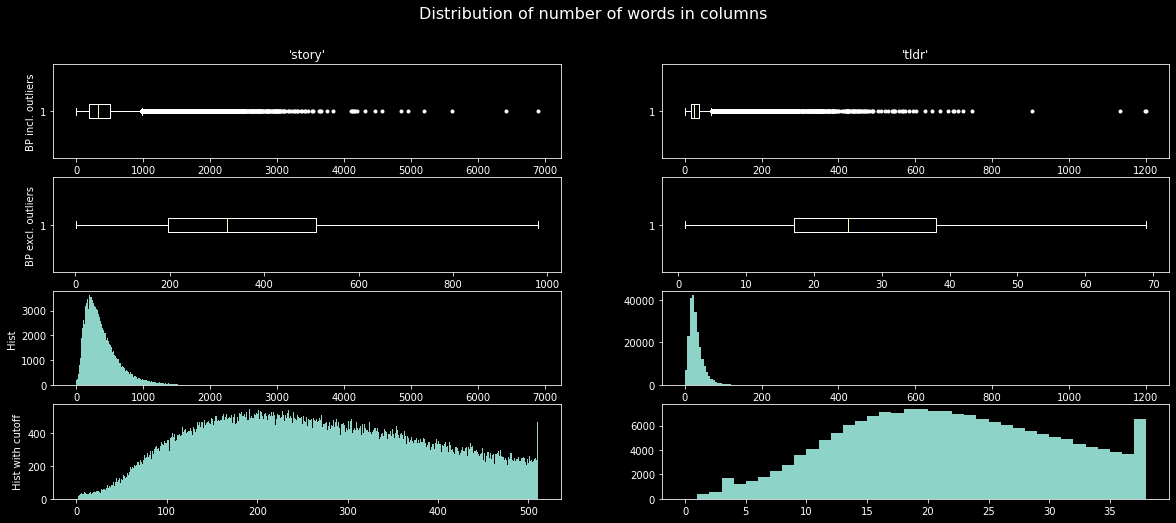


KPIs of number of words in column 'story'
count    235888.000000
mean        395.386361
std         292.045850
min           2.000000
25%         197.000000
50%         322.000000
75%         510.000000
max        6889.000000
Name: story_len, dtype: float64

KPIs of number of words in column 'tldr'
count    235888.000000
mean         31.269513
std          26.152672
min           1.000000
25%          17.000000
50%          25.000000
75%          38.000000
max        1201.000000
Name: tldr_len, dtype: float64


In [ ]:
fig, axs = plt.subplots(4, 2,figsize=(20,8))
flierprops = dict(marker='o', markerfacecolor='w', markersize=3,
                  linestyle='none', markeredgecolor='w')


fig.suptitle('Distribution of number of words in columns', fontsize=16)

bp1 = axs[0, 0].boxplot(df['story_len'], 
                        vert=False,
                        flierprops=flierprops)
for element in ['boxes', 'whiskers', 'fliers', 'caps']:
    plt.setp(bp1[element], color='white')

axs[0, 0].set_title('\'story\'')
axs[0, 0].set(ylabel='BP incl. outliers')

bp2 = axs[1, 0].boxplot(df['story_len'], 
                        vert=False, 
                        showfliers=False,
                        flierprops=flierprops)

axs[1, 0].set(ylabel='BP excl. outliers')

axs[2, 0].hist(df['story_len'], 
               bins = 1000)
axs[2, 0].set(ylabel='Hist')

axs[3, 0].hist(df['story_len'], 
               bins = int(df.story_len.quantile(0.75)), 
               range = (0, df.story_len.quantile(0.75)))
axs[3, 0].set(ylabel='Hist with cutoff')

bp3 = axs[0, 1].boxplot(df['tldr_len'], 
                        vert=False,
                        flierprops=flierprops)
axs[0, 1].set_title('\'tldr\'')

bp4 = axs[1, 1].boxplot(df['tldr_len'], 
                        vert=False, 
                        showfliers=False,
                        flierprops=flierprops)

axs[2, 1].hist(df['tldr_len'], 
               bins = 200)

axs[3, 1].hist(df['tldr_len'], 
               bins = int(df.tldr_len.quantile(0.75)), 
               range = (0, df.tldr_len.quantile(0.75)))

for bp in [bp1, bp2, bp3, bp4]:
  for element in ['boxes', 'whiskers', 'fliers', 'caps']:
    plt.setp(bp[element], color='white')

plt.show()

print('')
print('KPIs of number of words in column \'story\'')
print(df.story_len.describe())

print('')
print('KPIs of number of words in column \'tldr\'')
print(df.tldr_len.describe())

All the insights gained have been taken into considerization when deciding on boundaries for max/min length for each column.

Main aspects:
* Short stories/tldrs dont offer enough information for the model -> No text beneath length < 100 for stories, < 10 for tldr
* Long texts increase the computation power needed significantly. -> No text above length > 250 for stories, > 35 for tldr
* The dataset is very large, but should not get shrinked down too much. -> Goal is to keep atleast 50.000 observations

In [ ]:
num_before = df.shape[0]
print(f'Number of observations before dropping texts too long / too short: {num_before}')

df = df[((df['story_len']>100)&(df['story_len']<250)) & ((df['tldr_len']>10)&(df['tldr_len']<35))]

num_after = df.shape[0]
print(f'Observations dropped: {num_before - num_after}')
print(f'Number of observations before dropping texts too long / too short: {df.shape[0]}')

Number of observations before dropping texts too long / too short: 235888
Observations dropped: 185034
Number of observations before dropping texts too long / too short: 50854


### Reset index

Removing observations can result in missing indexes inbetween indexes. Thus, they get resetted.

In [ ]:
df.reset_index(drop=True, inplace=True)

### Check number of observations left after cleaning

In [ ]:
num_rows_after_dc = df.shape[0]

print(f'Number of observations after data cleaning: {num_rows_before_dc}')
print(f'Number of observations after data cleaning: {num_rows_after_dc}')

Number of observations after data cleaning: 404155
Number of observations after data cleaning: 50854


### Save dataset cleaned.

In [ ]:
df.to_pickle(file + 'combined_reddit_data_clean.pkl')

# Data Visualization & Analyisis

Despite visualizing and analysing the cleaned up dataset is not mandatory for the modelling process, it is done in this notebook to get a better understanding of the texts **and** to present NLP-skills i obtained throughout my eXSem.

Following parts will be analysed and visualized:

Text's...
* ... Lengths
* ... most frequent used words
* ... Sentiments
* ... Topics 



### Load cleaned dataset

In [ ]:
df = pd.read_pickle(file + 'combined_reddit_data_clean.pkl')

## Lemmatization

Lemmatisation is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

Example:

In [ ]:
print(f'Original:    {df.tldr.iloc[0]}')
print(f'Lemmatized:  {" ".join([y.lemma_ for y in en_core(df.tldr.iloc[0])])}')

Original:    GF spent NYE with her friends instead of our family. Should I say something about it or just go on as if nothing happened?
Lemmatized:  GF spend NYE with -PRON- friend instead of -PRON- family . Should -PRON- say something about -PRON- or just go on as if nothing happen ?


Lemmatize each text with spacy (carefull: this step takes long).

In [ ]:
df["story_lem"] = df['story'].apply(lambda x: " ".join([y.lemma_ for y in en_core(x)]))
df['story_lem_nopron'] = df['story_lem'].apply(lambda x: re.sub(r'-PRON-', '', x, flags = re.IGNORECASE))

df["tldr_lem"] = df['tldr'].apply(lambda x: " ".join([y.lemma_ for y in en_core(x)]))
df['tldr_lem_nopron'] = df['tldr_lem'].apply(lambda x: re.sub(r'-PRON-', '', x, flags = re.IGNORECASE))

Save dataset with lemmas.

In [ ]:
df.to_pickle(file + 'combined_reddit_data_clean_lem.pkl')
#df = pd.read_pickle(file + 'combined_reddit_data_clean_lem.pkl')

## Analysis of text-lengths

Checking the length of the texts once again to make sure they are distributed well.

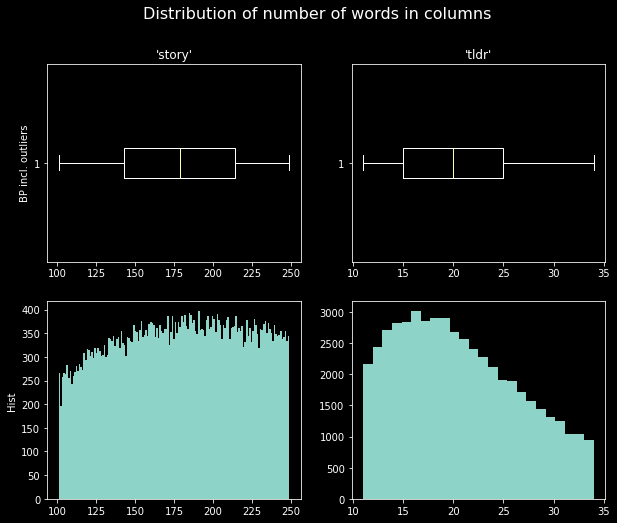


KPIs of number of words in column 'story'
count    50854.000000
mean       177.980218
std         41.675245
min        101.000000
25%        143.000000
50%        179.000000
75%        214.000000
max        249.000000
Name: story_len, dtype: float64

KPIs of number of words in column 'tldr'
count    50854.000000
mean        20.565423
std          6.249293
min         11.000000
25%         15.000000
50%         20.000000
75%         25.000000
max         34.000000
Name: tldr_len, dtype: float64


In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(10,8))

fig.suptitle('Distribution of number of words in columns', fontsize=16)

bp1 = axs[0, 0].boxplot(df['story_len'], 
                        vert=False)
axs[0, 0].set_title('\'story\'')
axs[0, 0].set(ylabel='BP incl. outliers')

axs[1, 0].hist(df['story_len'], 
               bins = 149)
axs[1, 0].set(ylabel='Hist')

bp2 = axs[0, 1].boxplot(df['tldr_len'], 
                        vert=False)
axs[0, 1].set_title('\'tldr\'')

axs[1, 1].hist(df['tldr_len'], 
               bins = 24)

for bp in [bp1, bp2]:
  for element in ['boxes', 'whiskers', 'fliers', 'caps']:
    plt.setp(bp[element], color='white')

plt.show()

print('')
print('KPIs of number of words in column \'story\'')
print(df.story_len.describe())

print('')
print('KPIs of number of words in column \'tldr\'')
print(df.tldr_len.describe())

**Result:** Text length of stories are distributed farily even. Text length of TLDRs are distributed more towards the lower boundary.

## Visualization of words frequently used

In order to illustrate words used most frequently, wordclouds are a great tool to get insights.

Compute wordclouds.

In [ ]:
wordcloud_story = WordCloud(background_color="black",width=1000, height=500).generate(' '.join(df['story_lem_nopron'].tolist()))
wordcloud_tldr = WordCloud(background_color="black",width=1000, height=500).generate(' '.join(df['tldr_lem_nopron'].tolist()))

Visualize wordclouds.

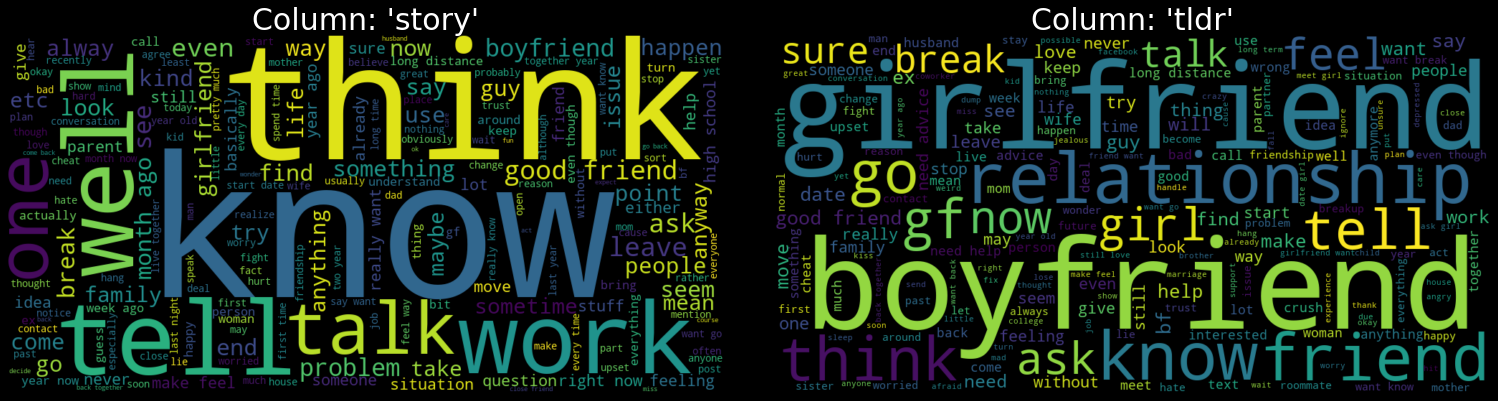

In [ ]:
plt.figure(figsize=(22,11), facecolor='k', edgecolor = 'k')

plt.subplot(1,2,1)
plt.imshow(wordcloud_story, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=5)
plt.title('Column: \'story\'', color = 'white', fontsize=30)

plt.subplot(1,2,2)
plt.imshow(wordcloud_tldr, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=5)
plt.title('Column: \'tldr\'', color = 'white', fontsize=30)

plt.show()

**Interpretation:** In the column 'story', we can see verbs, adjectives and adverbs compared to column 'tldr', where nouns are used most frequently. This was to be expected, as the TLDRs are more straight to the point and have less room these words. 

## Sentiment Analysis

Detecting whether stories have a positive or negative sentiment. Since the data is not labeled for this task, NLTKs pretrained SentimentIntensityAnalyzer is used for this task.

In [ ]:
sid = SentimentIntensityAnalyzer()

#Calculate sentiment scores
df['story_sent_scores'] = df['story_lem'].apply(lambda x: sid.polarity_scores(x))
df['tldr_sent_scores'] = df['tldr_lem'].apply(lambda x: sid.polarity_scores(x))

#Extract compound value (value between +1: positive and -1: negative)
df['story_sent_cmp']  = df['story_sent_scores'].apply(lambda x: x['compound'])
df['tldr_sent_cmp']  = df['tldr_sent_scores'].apply(lambda x: x['compound'])

#Reduce compound to binary info: either 'pos' or 'neg'
df['story_sent_bin'] = df['story_sent_cmp'].apply(lambda x: 'pos' if x >=0 else 'neg')
df['tldr_sent_bin'] = df['tldr_sent_cmp'].apply(lambda x: 'pos' if x >=0 else 'neg')

#Extract whether sentiment analysis matches in story and tldr
def create_match(story,tldr):
    if story == tldr:
      sent_match = 'match'
    elif story != tldr:
      sent_match = 'no match'
    return sent_match

df['sent_match'] = df.apply(lambda x: create_match(x.story_sent_bin, x.tldr_sent_bin), axis=1)

Visualize sentiments.

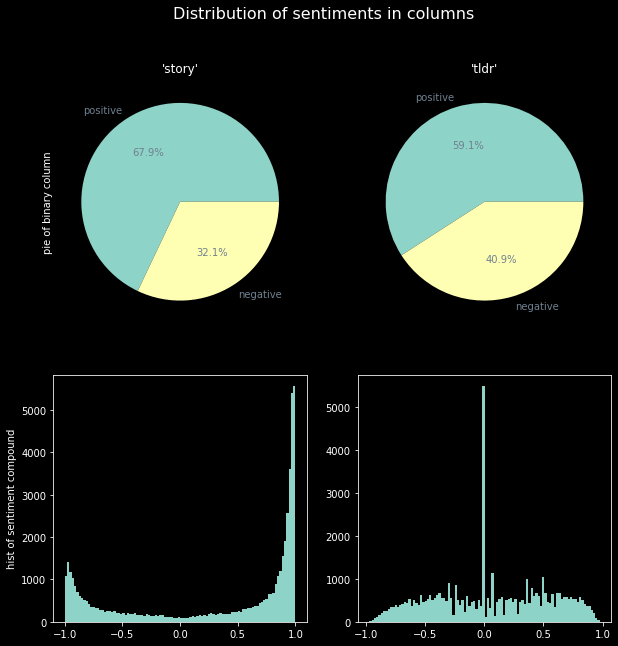

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('Distribution of sentiments in columns', fontsize=16)

#First row
axs[0, 0].pie(df['story_sent_bin'].value_counts(), 
              labels = ['positive', 'negative'],
              autopct='%1.1f%%',
              textprops=dict(color="slategrey"))
axs[0, 0].set_title('\'story\'')
axs[0, 0].set(ylabel='pie of binary column')

axs[0, 1].pie(df['tldr_sent_bin'].value_counts(), 
              labels = ['positive', 'negative'],
              autopct='%1.1f%%',
              textprops=dict(color="slategrey"))
axs[0, 1].set_title('\'tldr\'')

#Second row
axs[1, 0].hist(df['story_sent_cmp'], bins = 100)
axs[1, 0].set(ylabel='hist of sentiment compound')

axs[1, 1].hist(df['tldr_sent_cmp'], bins = 100)

plt.show()

**Interpretation:** Stories are classified as 'positive' more often than their summaries. This is a suprise, since people usually post about problems in their relationships rather then telling positive stories. Therefore, we should check these results very closely to be taken valid.

The percentage of positive / negative classified differ in the columns, which means, they do not match in every observation.

Interestingly, the distribution of the scores (range vom -1 to 1) is very different in the columns. A possible explanation could be, that we have seen much more verbs and adjectives in the stories than in the tldrs (which influences sentiment more) and thus pushes the score more towards the outer boundaries.

How often are sentiments not matching across story and its TLDR?

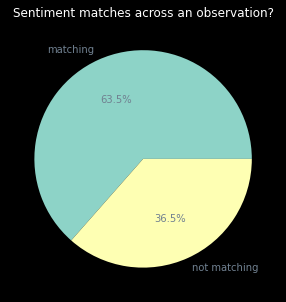

In [ ]:
plt.figure(figsize=(5,5))

plt.pie(df['sent_match'].value_counts(), 
        labels = ['matching', 'not matching'],
              autopct='%1.1f%%',
              textprops=dict(color="slategrey"))
plt.title('Sentiment matches across an observation?')

plt.show()

Lastly, check some examples for positive and negativ classified texts to see how well the model did (only TLDRs, since stories are too long).

In [ ]:
for sent in ['pos', 'neg']:
  print(f'Sentences with {sent}.-classified sentiment')
  for i in range(10):
    print(f'{i+1}: {df.tldr[df.tldr_sent_bin == sent].iloc[i]}')
  print('')  

Sentences with pos.-classified sentiment
1: gf spent nye with her friends instead of our family. should i say something about it or just go on as if nothing happened?
2: boyfriend stalked the girl he calls the one that got away.
3: how do i tell my parents where i'm spending my nights? try to keep the guy a secret? fess up?
4: i date/pursue people who aren’t actually available. i think it might be a reflection on myself.
5: best friend is seeing someone else and i don't know how to move forward
6: i feel like i cant help myself to keep this relationship.
7: how to make a long distance work when one partner works for 14hrs a day and has barely any time to talk or engage.
8: my mum said my cat would be fine for fireworks to get me out the house, then said she didn't really know.
9: boyfriend less enthused about marriage than i am, but is otherwise a great partner. i feel insecure because of this: should i be?
10: i’m co-dependent in my friendships which causes rifts between myself and my

**Interpreation:** As suspected previously, these samples show that the predicted sentinents do not match the texts too well. Luckily, we dont need them for further steps. :)

## Topic modelling 

Clustering the posts with unsupervised words. As a method, we will use Latent Dirichlet Allocation, which clusters documents according to their most frequently used words in *n* clusters, given by the programmer beforehand. 

Apply CountVectorizer, which clears stop-words and only keeps words used in more than 70% of the texts, but atleast appear five times.

In [ ]:
cv = CountVectorizer(max_df=0.7, min_df=5, stop_words='english')
ptm = cv.fit_transform(df['story_lem_nopron'])

Loop over 7 solutions (3 to 10 clusters), fit LDA and print clusters / possible topics described by their top-20 words in each solution.

In [ ]:
topic_labels = {}

for c in range(3,11):
  print(f'Solution: {c} Clusters')

  LDA = LatentDirichletAllocation(n_components=c,random_state=1)
  LDA.fit(ptm)

  topic_prob = LDA.transform(ptm)
  topic_labels[c] = topic_prob.argmax(axis=1)

  for index,topic in enumerate(LDA.components_):
    print(f'Top 20 words for topic #{index+1}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-20:]])
  print('')

Solution: 3 Clusters
Top 20 words for topic #1
['life', 'good', 'try', 'tell', 'make', 'say', 'month', 'really', 'think', 'thing', 'break', 'time', 'love', 'like', 'year', 'know', 'just', 'relationship', 'feel', 'want']
Top 20 words for topic #2
['good', 'make', 'feel', 'year', 'tell', 'meet', 'guy', 'think', 'ask', 'time', 'say', 'want', 'date', 'talk', 'girl', 'really', 'know', 'just', 'like', 'friend']
Top 20 words for topic #3
['week', 'home', 'really', 'night', 'thing', 'come', 'live', 'think', 'year', 'ask', 'make', 'know', 'day', 'like', 'work', 'want', 'time', 'tell', 'just', 'say']

Solution: 4 Clusters
Top 20 words for topic #1
['good', 'try', 'friend', 'make', 'tell', 'think', 'say', 'month', 'really', 'thing', 'year', 'break', 'time', 'love', 'like', 'know', 'just', 'relationship', 'want', 'feel']
Top 20 words for topic #2
['family', 'life', 'meet', 'good', 'thing', 'time', 'friend', 'school', 'make', 'feel', 'people', 'date', 'think', 'just', 'really', 'relationship', 'kno

Based on the eachs clusters top 20 words, we can guess what cluster/topic is about. The solution, where each cluster was interpreted the best, was chosen to be the solution of choice.

**Interpreation:** We decide for solution 7 - seven clusters with the following topics:
1. uncertainty and advice seeking
2. family planning
3. income and work
4. chatting and social media
5. long distance relationship
6. dating advice seeking
7. dating or relationship uncertainty

In [ ]:
num_clusters_final = 7
topic_names = {0:'uncertainty and advice seeking',
               1:'family planning',
               2:'income and work',
               3:'chatting and social media',
               4:'long distance relationship',
               5:'dating advice seeking',
               6:'dating or relationship uncertainty'}

df["topic"] = topic_labels[num_clusters_final]
df["topic"].replace(topic_names, inplace=True)

Check distributions of the clusters.

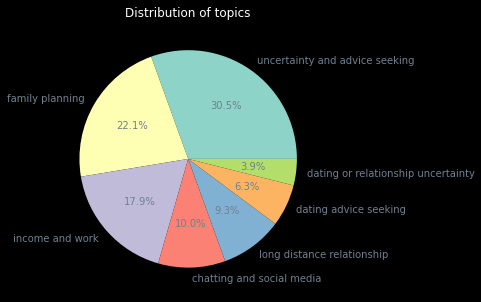

In [ ]:
plt.figure(figsize=(5,5))

plt.pie(df['topic'].value_counts(), 
        labels = topic_names.values(),
        autopct='%1.1f%%',
        textprops=dict(color="slategrey"))
plt.title('Distribution of topics')

plt.show()

**Interpreation**: The higher the cluster-index, the more often it appears across the texts.
The least well interpretable clusters 'dating advice seeking' & 'dating or relationship uncertainty' are the rarest.

As a last step, check wordclouds for each cluster.

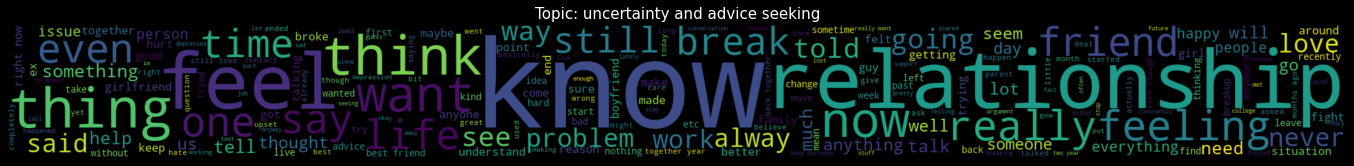

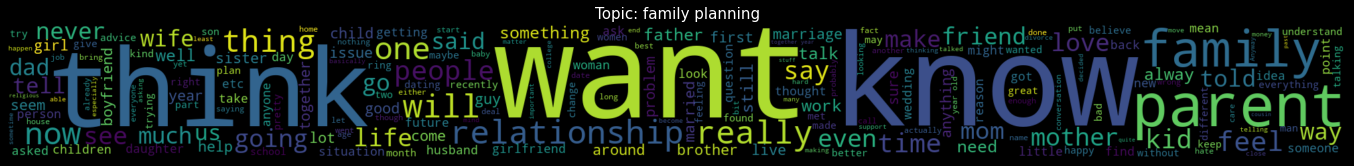

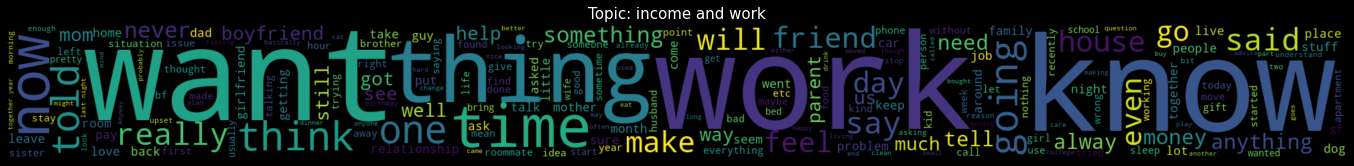

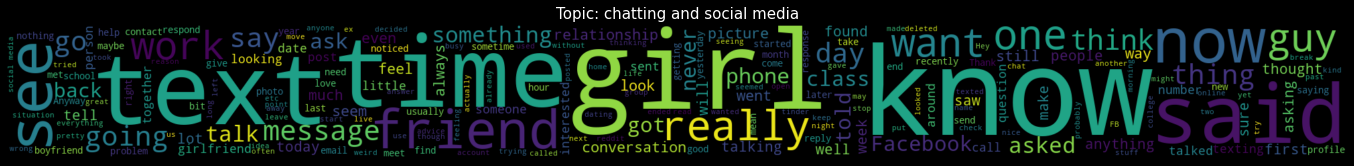

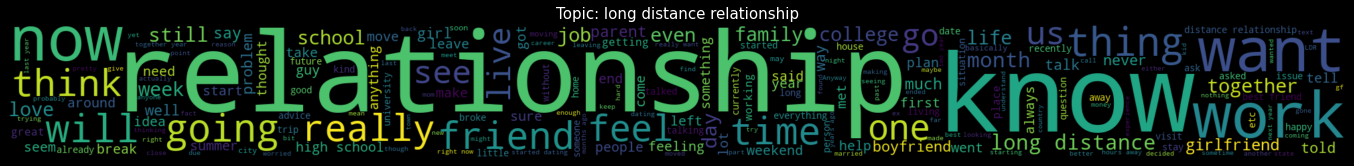

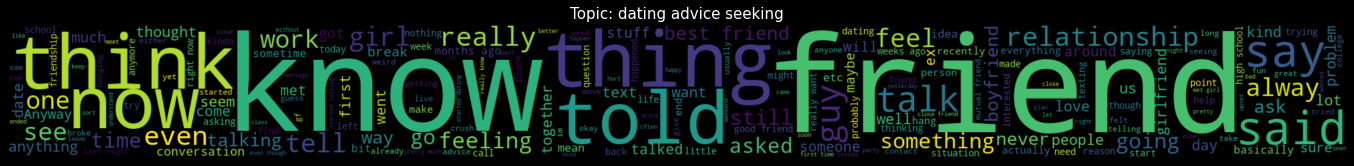

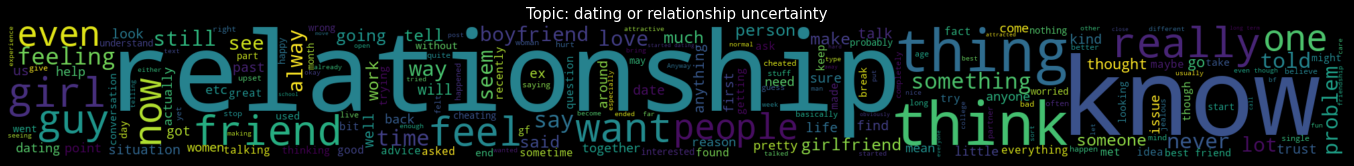

In [ ]:
for t in range(num_clusters_final):
  subset = df.story[df.topic==topic_names[t]]
  wc = WordCloud(background_color="black",width=2000, height=200).generate(' '.join(subset.tolist()))

  plt.figure(figsize=(20,10), facecolor='k', edgecolor = 'k')

  plt.imshow(wc, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=5)
  plt.title(f'Topic: {topic_names[t]}', color = 'white', fontsize=15)

  plt.show()

End of data visualization and analysis.

Next notebook: modelling.ipynb